In [1]:
%matplotlib widget
from skimage import io, exposure
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from traitlets import HasTraits, CFloat, observe

## Problem

Many microscopy images are difficult see the detail because the entire dynamic range is kept in the file. So you can't see the beautiful yeast in the below image.

In [2]:
yeast = io.imread('yeast.tif')
plt.figure()
plt.imshow(yeast)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Partial Solution

Clip the image using numpy. This allows you to start seeing the image, but adjusting this is annoying. Ideally I would use a selection slider over the histogram of pixel intensity which is was what is done in other image viewer software. 

In [3]:
clipped = np.clip(yeast,0,1000)
plt.figure()
plt.imshow(clipped)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Approach to nice thresholding with traitlets - tragically laggy :(

I think most of the lag is due to matplotlib recomputing the images and there being many roundtrips from python to javascript. I wonder if
1. Any way to make ipympl speedier
2. throttle traitlets updates

In [4]:
out = widgets.Output()

In [5]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines

out.clear_output()
# based on https://stackoverflow.com/questions/47439355/draggable-lines-select-one-another-in-matplotlib
class draggable_vline(HasTraits):
    position = CFloat(.5)
    def __init__(self, ax, position = .5, **kwargs):
        super().__init__(position=position, **kwargs)
        self.ax = ax
        self.fig = ax.get_figure()
        self.canvas = self.fig.canvas

        self.line = self.ax.axvline(position, picker=5,color='k')
        self.canvas.draw_idle()
        self.sid = self.canvas.mpl_connect('pick_event', self.clickonline)
        self.position = position

    def clickonline(self, event):
        with out:
            if event.artist == self.line:
                self.follower = self.canvas.mpl_connect("motion_notify_event", self.followmouse)
                self.releaser = self.canvas.mpl_connect("button_press_event", self.releaseonclick)

    def followmouse(self, event):
        with out:
            if event.xdata:
                self.line.set_xdata([event.xdata, event.xdata])
                self.canvas.draw_idle() # hide behind an if in case on same canvas as image?
                self.position = event.xdata

    def releaseonclick(self, event):
        self.canvas.mpl_disconnect(self.releaser)
        self.canvas.mpl_disconnect(self.follower)

class percentile_threshold(HasTraits):
    lower_threshold = CFloat(0)
    upper_threshold = CFloat(1)
    
    def __init__(self, ax, data, min_percentile, max_percentile, bins=100, **kwargs):
        super().__init__(**kwargs)
        self.ax = ax
        self.fig = ax.get_figure()
        self.canvas = self.fig.canvas
        self.ax.hist(data,bins=bins, density=True)
        self.min_percentile = min_percentile # add option for these to be iterable?
        self.max_percentile = max_percentile
        self.line1 = draggable_vline(ax, self.lower_threshold*data.max())
        self.line2 = draggable_vline(ax, self.upper_threshold*data.max())
        self.line1.observe(self._handle_position_change)
        self.line2.observe(self._handle_position_change)
        self.canvas.draw()
        self._max_val = data.max()

    def _handle_position_change(self, change):
        with out:
            self.lower_threshold, self.upper_threshold = np.sort([self.line1.position, self.line2.position])/self._max_val

class thresholded_image(HasTraits):
    max_percentile = CFloat(1)
    min_percentile = CFloat(0)
    def __init__(self, ax, image, **kwargs):
        super().__init__(**kwargs)
        self.ax = ax
        self.fig = ax.get_figure()
        self.canvas = self.fig.canvas
        self.image = image
        self.im = self.ax.imshow(image)
        self.canvas.draw_idle()
        self._img_max = self.image.max()
        self._img_min = self.image.min()
        
    @observe('max_percentile', 'min_percentile')
    def _observe_max_value(self, change):
        self.im.set_data(np.clip(self.image, self._img_max*self.min_percentile, self.max_percentile * self._img_max))
        self.canvas.draw_idle()
        
    
plt.ioff()
fig = plt.figure(figsize=(14,6))
im_ax, hist_ax = fig.subplots(1, 2)

yikes = thresholded_image(im_ax, clipped)
hist = percentile_threshold(hist_ax, clipped.ravel(), 0, 1)
def callback(change):
    with out:
        yikes.min_percentile = hist.lower_threshold
        yikes.max_percentile = hist.upper_threshold
        yikes.im.autoscale()

hist.observe(callback)
plt.ion()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Try with throttling
Code yoinked from: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Throttling 

In [6]:
from time import time

import asyncio

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback
        self._task = asyncio.ensure_future(self._job())

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def cancel(self):
        self._task.cancel()

def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled = False
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args = args
            new_kwargs = kwargs
            if not scheduled:
                new_wait = max(0, wait - time_since_last_call)
                Timer(new_wait, call_it)
                scheduled = True
        return throttled
    return decorator

In [7]:
out.clear_output()

In [8]:

plt.ioff()
fig = plt.figure(figsize=(14,6))
im_ax, hist_ax = fig.subplots(1, 2)
display(out)
yikes = thresholded_image(im_ax, clipped)
hist = percentile_threshold(hist_ax, clipped.ravel(), 0, 1)
@throttle(.5)
def callback(change):
    with out:
        print('here!')
        yikes.min_percentile = hist.lower_threshold
        yikes.max_percentile = hist.upper_threshold
        yikes.im.autoscale()

hist.observe(callback)
plt.ion()
plt.show()

Output()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## How to improve?


Add scroll to zoom on the histogram once ipympl 0.5.7 is released

I think the best approach is to make both parts in the javascript separately then use jslink to connect the values. I don't really want to write my own histogram and selection range thingy so maybe should look in bqplot.


D3 seems like an extreme choice. Maybe could start using p5js as a dependency. Example hist of image: https://editor.p5js.org/ebenjmuse/sketches/HyPfeGkCZ

oh boy i sure didn't do enough research on the canvas libraries. Also fabricjs, paperjs, and easeljs

how on earth are you supposed to choose

from: https://www.slant.co/topics/28/~best-javascript-drawing-libraries
single instance thing may be an issue.
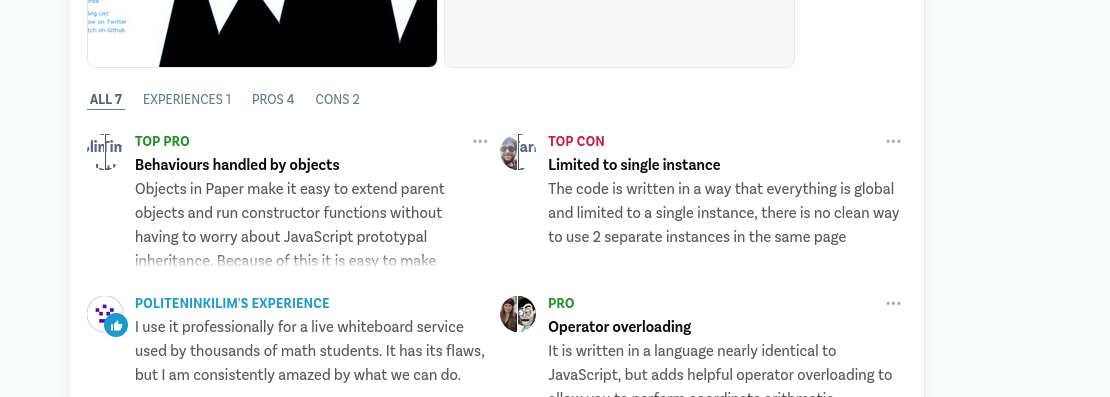


maybe chartjs is the way to go could use for histogram and also here is an example of selecting a range https://stackoverflow.com/questions/42855738/how-do-i-selecting-a-date-range-like-onclick-but-drag-select 

I probably ought to learn one of the canvas libraries though. But also maybe not??? LIke I'm not try to make a game here all the visualization an interaction is hopefully simple. But still would be faster to make if I just glommed on lots of stuff

In [ ]:

# #         print('wow!')
# hist.observe(callback)
# plt.ion()
# plt.show()

# plt.close('all')
# plt.ioff()
# fig = plt.figure()
# ax = fig.gca()

# display(out)

# fig2 = plt.figure()
# fig.canvas2
# ax2 = fig2.add_subplot(111)
# hist = percentile_threshold(ax2, clipped.ravel(), 0, 1)
# def callback(change):
#     with out:
#         yikes.min_percentile = hist.lower_threshold
#         yikes.max_percentile = hist.upper_threshold
#         yikes.im.autoscale()
# #         print('wow!')

# widgets.HBox([fig.canvas, fig2.canvas])
# # hist = threshold_hist(ax2, clipped, .1, 4)
# # Vline = draggable_vline(ax2, 1,.2)
# # Vline.observe(callback)
# # Vline = draggable_vline(ax, 0.8)
# # Tline = draggable_lines(ax, "v", 0.5)
# # Tline2 = draggable_lines(ax, "v", 0.1)
# # plt.show()